### Tittle option
# Option 1: Snowpark Python: Run your Data Science where your data lives: A hands-on guide

# Option 2: Snowpark Python: How to migrate your DS projects.

**[Python for Snowpark](https://www.snowflake.com/news/snowflake-expands-native-python-support-and-data-access-to-advance-programmability-in-the-data-cloud/)** has just been released, and now we have the ability to run our models closer of were our data lives, using Snowflake procesing power to run our model prediction. 

In this example we're going to take a fairly known dataset **[California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)**, upload the data  into Snowflake using **Snowpark for Python**, we will do a quick data exploration, crossvalidation and fine-tunning, to then deploy our model into Snowflake to get our predictions using Snowflake's data warehouse. 



## 1. Load necesary Snowpark packages and connect to Snowflake

We will begin by importing necesary libraries, the session class will give us everything we need to connect to Snowflake, using the same parameters from the connect function in the Snowflake Connector for Python. To create a session we will build a Python dictionary containing the names and values of the parameters, see example below. 

For this example, we placed those parameters in a different file called "config".

In [ ]:
import os

connection_parameters = {
    "account": os.environ["snowflake_account"],
    "user": os.environ["snowflake_user"],
    "password": os.environ["snowflake_password"],
    "role": os.environ["snowflake_user_role"],
    "warehouse": os.environ["snowflake_warehouse"],
    "database": os.environ["snowflake_database"],
    "schema": os.environ["snowflake_schema"]
  }

We will also import standart machine learning libraries like pandas, numpy and Matplotlib, and several snowpark libraries like "functions" that provides utility and SQL functions to generate column expressions to pass to DataFrame transformation methods, date types, and UDF to build our predictions in Snowflake. 



In [1]:
# Snowflake packages
import snowflake.snowpark
from snowflake.snowpark.functions import sproc
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
from snowflake.snowpark.functions import udf

#Python packages
import sys
import cachetools
import os
import pandas as pd
import numpy as np
import io
import joblib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

#Snowflake connection info is saved in config.py
from config import snowflake_conn_prop



Print Snowpark version

In [64]:
from snowflake.snowpark import version
print(version.VERSION)

(0, 6, 0, None)


We'll load our data using pd.read() and pull a sample.

In [65]:
#Read the housing data

data=pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv')
#this one will work once we release and make the repo public
## TODO : Include public URL
#You can download the data from our public repo
#data=pd.read_csv('https://raw.githubusercontent.com/Hakkoda1/Snowpark_migrate/main/housing.csv')

data.columns= ['LONGITUDE',
 'LATITUDE',
 'HOUSING_MEDIAN_AGE',
 'TOTAL_ROOMS',
 'TOTAL_BEDROOMS',
 'POPULATION',
 'HOUSEHOLDS',
 'MEDIAN_INCOME',
 'MEDIAN_HOUSE_VALUE',
 'OCEAN_PROXIMITY']

In [66]:
data.head()

,LONGITUDE,LATITUDE,HOUSING_MEDIAN_AGE,TOTAL_ROOMS,TOTAL_BEDROOMS,POPULATION,HOUSEHOLDS,MEDIAN_INCOME,MEDIAN_HOUSE_VALUE,OCEAN_PROXIMITY
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Now let's create a connection.

We will pass the dictionary containing the name and values of the parameters from config.py to the session.builder.configs method to return a object with the parameters to call th create method and stablish connection.

In [2]:
session = Session.builder.configs(snowflake_conn_prop).create()


To create our environment in snowflake you can load different variables with the rolename, database, schema, warehouse name and create them running SQL in Snowflake with the session.sql command. You can update these to adapt your snowflake environment, just make sure the role has create priviledges for the database.
Snowpark operations are lazy, which means that to trigger queries you need to call and action function, like the collect function.


In [3]:
rolename = "SYSADMIN"
dbname = "DEMO"
schemaname = "TEST"
warehouse = "HOUSING_LAB_SNOW"

session.sql(f"USE ROLE {rolename}").collect()

[Row(status='Statement executed successfully.')]

In [7]:
#  Create a database, schema, warehouse)
session.sql(f"CREATE DATABASE IF NOT EXISTS {dbname}").collect()
session.sql(f"CREATE SCHEMA IF NOT EXISTS {dbname}.{schemaname}").collect()
session.sql(f"CREATE WAREHOUSE  IF NOT EXISTS {warehouse} \
                WAREHOUSE_SIZE = 'Large' \
                AUTO_SUSPEND = 300 \
                AUTO_RESUME = TRUE \
                MIN_CLUSTER_COUNT = 1 \
                MAX_CLUSTER_COUNT = 3 \
                SCALING_POLICY = 'STANDARD' ").collect()

[Row(status='HOUSING_LAB_SNOW already exists, statement succeeded.')]

In [4]:
session.sql(f"USE WAREHOUSE {warehouse}").collect()
session.sql(f"USE SCHEMA {dbname}.{schemaname}").collect()

[Row(status='Statement executed successfully.')]

In [5]:
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_WAREHOUSE()='HOUSING_LAB_SNOW', CURRENT_DATABASE()='DEMO', CURRENT_SCHEMA()='TEST')]


In [6]:
session.add_packages('snowflake-snowpark-python', 'scikit-learn', 'pandas', 'numpy', 'joblib', 'cachetools', 'xgboost')

Now, to explain the whole process, we will load our csv into Snowflake and use it for our analysis, in your case the data might already be in Snowflake.

The following variable names contain our file name, in this case, housing.csv, the name of the stage for the file, model and UDF, and the raw table name.

The session.fle.put command will load the file in the stage, 

Note: for this example it's important to have our file in the same folder as the notebook.



In [72]:
filename = "housing.csv"
stagename = "rawdata"
model_stage = "models"
rawtable = "housing"
udf="udf"

In [52]:
# Create Snowflake stage
session.sql(f"create or replace stage {stagename} DIRECTORY = (ENABLE = TRUE);").collect()

# Put the file in the stage
session.file.put(filename,stagename)

[PutResult(source='housing.csv', target='housing.csv.gz', source_size=1423529, target_size=396000, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

In [82]:
session.sql(f"create or replace stage {model_stage} DIRECTORY = (ENABLE = TRUE) copy_options = (on_error='skip_file');").collect()
session.sql(f"create or replace stage {udf} copy_options = (on_error='skip_file');").collect()

[Row(status='Stage area UDF successfully created.')]

Let's create our schema by using a SructType containing names of the columns and data types of such columns, then we'll call the schema property to return an object configured to read files containing the specified fields and with the options property we define the format fields like compressions, field delimiter, type and skipping the header, with the csv option we define the location of our file in the stage and then the copy into creates our table.

In [ ]:
schema_for_data_file = StructType([
    StructField("longitude",IntegerType()),
    StructField("latitude",IntegerType()),
    StructField("housing_median_age",IntegerType()),
    StructField("total_rooms",IntegerType()),
    StructField("total_bedrooms",IntegerType()),
    StructField("population",IntegerType()),
    StructField("households",IntegerType()),
    StructField("median_income",IntegerType()),
    StructField("median_house_value",IntegerType()),
    StructField("ocean_proximity",StringType())])


In [54]:
csv_reader=session.read.schema(schema_for_data_file)

In [55]:
format_options={"compression": "gzip",  "type" : "csv", "field_delimiter" : ",","skip_header": 1}
csv_reader=csv_reader.options(format_options)

In [56]:
df = csv_reader.csv("@rawdata/housing.csv.gz")

In [57]:
# In case you already have a table there

drop_result = session.sql(f"drop table if exists {rawtable}").collect() 
drop_result

[Row(status='HOUSING successfully dropped.')]

In [58]:
df_table=df.copy_into_table("housing",format_type_options=format_options ,force=True)

In [59]:
%%time

housing_snowflake = session.table('housing')

pd.pandas.set_option('display.max_columns', None)

data = housing_snowflake.toPandas()
data.head()

CPU times: user 620 ms, sys: 56.6 ms, total: 676 ms
Wall time: 3.12 s


,LONGITUDE,LATITUDE,HOUSING_MEDIAN_AGE,TOTAL_ROOMS,TOTAL_BEDROOMS,POPULATION,HOUSEHOLDS,MEDIAN_INCOME,MEDIAN_HOUSE_VALUE,OCEAN_PROXIMITY
0,-122,38,41,880,129.0,322,126,8,452600,NEAR BAY
1,-122,38,21,7099,1106.0,2401,1138,8,358500,NEAR BAY
2,-122,38,52,1467,190.0,496,177,7,352100,NEAR BAY
3,-122,38,52,1274,235.0,558,219,6,341300,NEAR BAY
4,-122,38,52,1627,280.0,565,259,4,342200,NEAR BAY


In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LONGITUDE           20640 non-null  float64
 1   LATITUDE            20640 non-null  float64
 2   HOUSING_MEDIAN_AGE  20640 non-null  float64
 3   TOTAL_ROOMS         20640 non-null  float64
 4   TOTAL_BEDROOMS      20433 non-null  float64
 5   POPULATION          20640 non-null  float64
 6   HOUSEHOLDS          20640 non-null  float64
 7   MEDIAN_INCOME       20640 non-null  float64
 8   MEDIAN_HOUSE_VALUE  20640 non-null  float64
 9   OCEAN_PROXIMITY     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Perform Exploratory Data Analysis (EDA)

Now that we have our data in Snowflake we can decide if we want to work with Snowpark python or with our preferred Python native libraries like numpy and pandas, but Snowpark offers the ability to run most of the analysis in Snowflake, preventing your data to leave your database.

We will perform a quick visual EDA starting with a histogram on numeric variables to see how our data is represented.

At first glance we can see that this attributes have very different ranges, we will work on this when we create our Snowpark function and do feature scaling with our transformation pipeline.

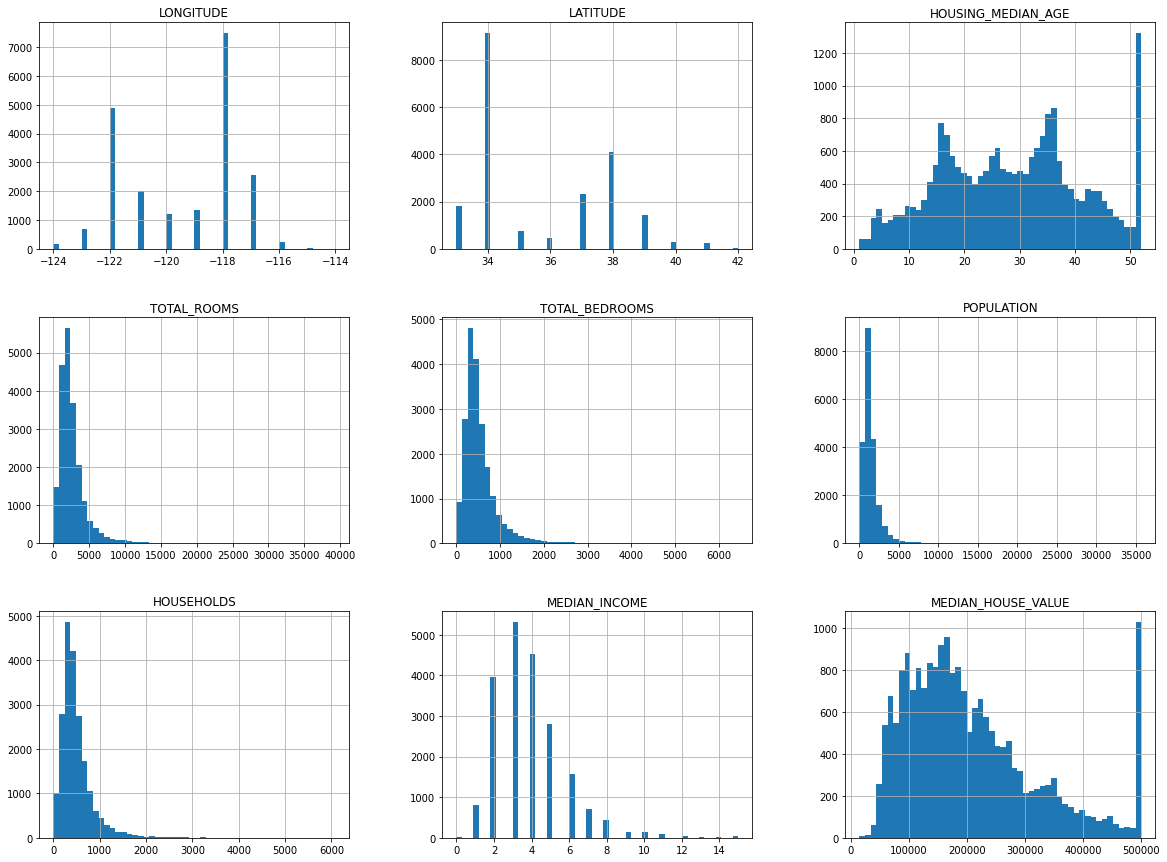

In [70]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [26]:
cat_vars = [var for var in data.columns if ((data[var].dtype == 'O') or (data[var].dtype=="bool"))]
print(cat_vars)

num_vars = [var for var in data.columns if var not in cat_vars]
print(num_vars)


['OCEAN_PROXIMITY']
['LONGITUDE', 'LATITUDE', 'HOUSING_MEDIAN_AGE', 'TOTAL_ROOMS', 'TOTAL_BEDROOMS', 'POPULATION', 'HOUSEHOLDS', 'MEDIAN_INCOME', 'MEDIAN_HOUSE_VALUE']



Median income is an important predictor for median housing prices, so we will create a new attribute with pd.cut() called INCOME_CAT, that will define 5 categories (labeled from 1 to 5) based on Median_INCOME cuts. 

In [27]:
data["INCOME_CAT"] = pd.cut(data["MEDIAN_INCOME"],
 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
 labels=[1, 2, 3, 4, 5])

Then some clean up is required, we will run code detect null values in our dataset.

In [28]:
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

mean_val=data[vars_with_na].isnull().sum().sort_values(ascending=False)
sum_val=data[vars_with_na].isnull().mean().sort_values(ascending=False)


Variables TOTAL_BEDROOMS and INCOME_CAT have 207 and 12 null values respectively.

In [29]:
pd.concat([mean_val.rename('sum'),sum_val.rename('mean')],axis=1)

,sum,mean
TOTAL_BEDROOMS,207,0.010029


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   LONGITUDE           20640 non-null  float64 
 1   LATITUDE            20640 non-null  float64 
 2   HOUSING_MEDIAN_AGE  20640 non-null  float64 
 3   TOTAL_ROOMS         20640 non-null  float64 
 4   TOTAL_BEDROOMS      20433 non-null  float64 
 5   POPULATION          20640 non-null  float64 
 6   HOUSEHOLDS          20640 non-null  float64 
 7   MEDIAN_INCOME       20640 non-null  float64 
 8   MEDIAN_HOUSE_VALUE  20640 non-null  float64 
 9   OCEAN_PROXIMITY     20640 non-null  object  
 10  INCOME_CAT          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


In this case, for example purposes, we're going to drop the na's but calculating the mean is also an option if the dataset is small and you need each and every row.

In [31]:
data=data.dropna(subset=['TOTAL_BEDROOMS','INCOME_CAT'])

In [32]:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   LONGITUDE           20433 non-null  float64 
 1   LATITUDE            20433 non-null  float64 
 2   HOUSING_MEDIAN_AGE  20433 non-null  float64 
 3   TOTAL_ROOMS         20433 non-null  float64 
 4   TOTAL_BEDROOMS      20433 non-null  float64 
 5   POPULATION          20433 non-null  float64 
 6   HOUSEHOLDS          20433 non-null  float64 
 7   MEDIAN_INCOME       20433 non-null  float64 
 8   MEDIAN_HOUSE_VALUE  20433 non-null  float64 
 9   OCEAN_PROXIMITY     20433 non-null  object  
 10  INCOME_CAT          20433 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.7+ MB


Now we will create a dataframe from the pandas dataset and load to snowflake our data without null values. Keep in mind that we performed this analysis in Python directly but you can also use snowpark functions to clear your null values. 

In [45]:
d2=session.create_dataframe(data)

In [61]:
d2.write.mode("overwrite").save_as_table("Data_no_nulls")

We're getting into the fun part, testing different machine learning algoritms and see how they perform in our data. 

We will create a python funtion that encapsulate everything we consider necesary to train our model in Snowflake. 

The function safe_file will drop our model into Snowflake so that we can call it and use it for inference after our training. 


In [7]:
def save_file(session, model, path):
  input_stream = io.BytesIO()
  joblib.dump(model, input_stream)
  session._conn._cursor.upload_stream(input_stream, path)
  return "successfully created file: " + path


The train_model function does exactly that, it trains our  into snowflake with the parameters we choose. 

The function have the following sections:

1. Ingestion: We will take our data cleaned from null values, and put it as a pandas dataframe. 

2. Split the train and test set: perform a stratified split of our data based on INCOME_CAT, this way we can be sure that our test set has almost the same proportion of income categories than the full dataset. Note: More on why this is important at reference 2 pag. 57 and 58. 
Then we will save the train and test set and get the data labels.

3.  Create a pipeline for numerical and categorical features: Here it's were the transformation process takes place, in summary we need to separate our numerical and categorical features to prepare them for training, in this case we're performing feature scaling to get all variables in the same scale and apply a one hot encoder to convert categories into numbers, fit preprocessing pipeline and the model and then save the model in the MODEL stage as .joblib file. The full_pipeline.transform will apply transformations done in the training set. In this case we will use the Random Forest regressor.


4. 


In [34]:


def train_model(session: snowflake.snowpark.Session) -> float:
    #1. Ingestion
    data_no_nulls = session.table("Data_no_nulls")
    data=data_no_nulls.to_pandas()
    #2. split the train and test set
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(data, data["INCOME_CAT"]):
        strat_train_set = data.iloc[train_index]
        strat_test_set = data.iloc[test_index]

    # save the train and test sets as time stamped tables in Snowflake 
    session.create_dataframe(strat_train_set).write.mode("overwrite").save_as_table("HOUSING_TRAIN")
    session.create_dataframe(strat_test_set).write.mode("overwrite").save_as_table("HOUSING_TEST")

    
    data = strat_train_set.drop(['MEDIAN_HOUSE_VALUE', 'INCOME_CAT'], axis=1)
    data_labels = strat_train_set["MEDIAN_HOUSE_VALUE"].copy()
    housing_test = strat_test_set.drop("MEDIAN_HOUSE_VALUE", axis=1)
    housing_test_labels = strat_test_set["MEDIAN_HOUSE_VALUE"].copy()
 
     #3. create a pipeline for numerical and categorical features
     
    # Get numerical features
    housing_num = data.drop("OCEAN_PROXIMITY", axis=1)
    num_pipeline = Pipeline([
            ('std_scaler', StandardScaler()),
        ])

    num_attribs = list(housing_num)
    cat_attribs = ["OCEAN_PROXIMITY"]

    preprocessor = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", OneHotEncoder(), cat_attribs)
        ])

    full_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', RandomForestRegressor(n_estimators=100, random_state=42)),
        ])

    # Fit the preprocessing pipeline and the model together
    full_pipeline.fit(data, data_labels)

    # save the full pipeline including the model
    save_file(session, full_pipeline, "@MODELS/housing_reg.joblib")

    #5 predict on the test set and return the root mean squared error (RMSE)
    housing_predictions = full_pipeline.predict(housing_test)
    lin_mse = mean_squared_error(housing_test_labels, housing_predictions)
    lin_rmse = np.sqrt(lin_mse)
    return lin_rmse

    #6 Create an instance of StoredProcedure using the sproc() function
train_model_sp = sproc(train_model, replace=True, session=session)

# Cross validation

In [ ]:

def train_model(session: snowflake.snowpark.Session) -> float:
    data_no_nulls = session.table("Data_no_nulls")
    data=data_no_nulls.to_pandas()
    # split the train and test set
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(data, data["INCOME_CAT"]):
        strat_train_set = data.iloc[train_index]
        strat_test_set = data.iloc[test_index]
    #strat_train_set, strat_test_set = data.random_split([0.8, 0.2], seed=82)

    # save the train and test sets as time stamped tables in Snowflake 
    session.create_dataframe(strat_train_set).write.mode("overwrite").save_as_table("HOUSING_TRAIN")
    session.create_dataframe(strat_test_set).write.mode("overwrite").save_as_table("HOUSING_TEST")

    
    data = strat_train_set.drop(['MEDIAN_HOUSE_VALUE', 'INCOME_CAT'], axis=1)
    data_labels = strat_train_set["MEDIAN_HOUSE_VALUE"].copy()
    housing_test = strat_test_set.drop("MEDIAN_HOUSE_VALUE", axis=1)
    housing_test_labels = strat_test_set["MEDIAN_HOUSE_VALUE"].copy()
 

#best practice of repeated k-fold cross-validation with 3 repeats and 10 folds. Check this fact
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # numerical features
    housing_num = data.drop("OCEAN_PROXIMITY", axis=1)
    # create a pipeline for numerical features
    num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ])
    data_num_tr = num_pipeline.fit_transform(housing_num)

    num_attribs = list(housing_num)
    cat_attribs = ["OCEAN_PROXIMITY"]
    
    preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    ])
    
    #data_prepared = preprocessor.fit_transform(data)

    full_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', RandomForestRegressor(n_estimators=100, random_state=42)),
        ])
    
    # fit the preprocessing pipeline and the model together
    full_pipeline.fit(data, data_labels)

    # save the full pipeline including the model
    save_file(session, full_pipeline, "@MODELS/housing_reg.joblib")

    #best practice of repeated k-fold cross-validation with 3 repeats and 10 folds. Check this fact
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    linear_scores = cross_val_score(full_pipeline, data, data_labels, scoring="neg_mean_squared_error", cv=cv)
    linear_rmse_scores = np.sqrt(-linear_scores)

    session.create_dataframe(pd.DataFrame(linear_rmse_scores, columns=['Scores'])).write.mode("overwrite").save_as_table("Results")
    return linear_rmse_scores.mean()

# Create an instance of StoredProcedure using the sproc() function
train_model_sp = sproc(train_model, replace=True,session=session)

# Parameter tunning

In [25]:

def train_model(session: snowflake.snowpark.Session) -> float:
    data_no_nulls = session.table("Data_no_nulls")
    data=data_no_nulls.to_pandas()
    # split the train and test set
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(data, data["INCOME_CAT"]):
        strat_train_set = data.iloc[train_index]
        strat_test_set = data.iloc[test_index]
    #strat_train_set, strat_test_set = data.random_split([0.8, 0.2], seed=82)

    # save the train and test sets as time stamped tables in Snowflake 
    session.create_dataframe(strat_train_set).write.mode("overwrite").save_as_table("HOUSING_TRAIN")
    session.create_dataframe(strat_test_set).write.mode("overwrite").save_as_table("HOUSING_TEST")

    
    data = strat_train_set.drop(['MEDIAN_HOUSE_VALUE', 'INCOME_CAT'], axis=1)
    data_labels = strat_train_set["MEDIAN_HOUSE_VALUE"].copy()
    housing_test = strat_test_set.drop("MEDIAN_HOUSE_VALUE", axis=1)
    housing_test_labels = strat_test_set["MEDIAN_HOUSE_VALUE"].copy()

#best practice of repeated k-fold cross-validation with 3 repeats and 10 folds. Check this fact
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # numerical features
    housing_num = data.drop("OCEAN_PROXIMITY", axis=1)
    # create a pipeline for numerical features
    num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ])
    data_num_tr = num_pipeline.fit_transform(housing_num)

    num_attribs = list(housing_num)
    cat_attribs = ["OCEAN_PROXIMITY"]
    
    preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    ])
    #data_prepared = preprocessor.fit_transform(data)
    full_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', RandomForestRegressor(random_state=42)),
        ])
    
    # fit the preprocessing pipeline and the model together
    full_pipeline.fit(data, data_labels)

    # save the full pipeline including the model
    save_file(session, full_pipeline, "@MODELS/housing_reg.joblib")

    #best practice of repeated k-fold cross-validation with 3 repeats and 10 folds. Check this fact
    rf_param_distribs = {'model__n_estimators': [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
    'model__max_features': ['auto', 'sqrt'],
    'model__max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
    'model__min_samples_split': [2, 6, 10],
    'model__min_samples_leaf':[1, 3, 4],
    'model__bootstrap': [True, False]}
    
    random_search = RandomizedSearchCV(full_pipeline, param_distributions=rf_param_distribs,
                                n_iter=50, cv=cv, scoring='neg_mean_squared_error',
                                verbose=1, random_state=42)

    random_search.fit(data, data_labels)
    
    negative_mse = random_search.best_score_
    rmse = np.sqrt(-negative_mse)
    #session.create_dataframe(pd.DataFrame(negative_mse, columns=['Scores'])).write.mode("overwrite").save_as_table("Results")
    return rmse



In [23]:

def train_model(session: snowflake.snowpark.Session, table:str, params_distr:dict, algorithm:str) -> float:
        models_select= {}
        xgb= XGBRegressor(nthreads=1, random_state=42)
        forest= RandomForestRegressor(random_state=42)   
        models_select["xgb"] = xgb
        models_select["forest"] = forest
        
        data_no_nulls = session.table(table)
        data=data_no_nulls.to_pandas()
        # split the train and test set
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        for train_index, test_index in split.split(data, data["INCOME_CAT"]):
            strat_train_set = data.iloc[train_index]
            strat_test_set = data.iloc[test_index]
        #strat_train_set, strat_test_set = data.random_split([0.8, 0.2], seed=82)

        # save the train and test sets as time stamped tables in Snowflake 
        session.create_dataframe(strat_train_set).write.mode("overwrite").save_as_table("HOUSING_TRAIN")
        session.create_dataframe(strat_test_set).write.mode("overwrite").save_as_table("HOUSING_TEST")

        
        data = strat_train_set.drop(['MEDIAN_HOUSE_VALUE', 'INCOME_CAT'], axis=1)
        data_labels = strat_train_set["MEDIAN_HOUSE_VALUE"].copy()
        housing_test = strat_test_set.drop("MEDIAN_HOUSE_VALUE", axis=1)
        housing_test_labels = strat_test_set["MEDIAN_HOUSE_VALUE"].copy()

    #best practice of repeated k-fold cross-validation with 3 repeats and 10 folds. Check this fact
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
        # numerical features
        housing_num = data.drop("OCEAN_PROXIMITY", axis=1)
        # create a pipeline for numerical features
        num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
        ])
        data_num_tr = num_pipeline.fit_transform(housing_num)

        num_attribs = list(housing_num)
        cat_attribs = ["OCEAN_PROXIMITY"]
        
        preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ])
        #data_prepared = preprocessor.fit_transform(data)
        full_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', models_select[algorithm]),
            ])
        
        # fit the preprocessing pipeline and the model together
        full_pipeline.fit(data, data_labels)

        # save the full pipeline including the model
        save_file(session, full_pipeline, "@MODELS/housing_reg.joblib")

        #best practice of repeated k-fold cross-validation with 3 repeats and 10 folds. Check this fact
    
        
        random_search = RandomizedSearchCV(full_pipeline, param_distributions=params_distr,
                                    n_iter=50, cv=cv, scoring='neg_mean_squared_error',
                                    verbose=1, random_state=42)

        random_search.fit(data, data_labels)
        
        negative_mse = random_search.best_score_
        rmse = np.sqrt(-negative_mse)
        #session.create_dataframe(pd.DataFrame(negative_mse, columns=['Scores'])).write.mode("overwrite").save_as_table("Results")
        return rmse

In [24]:
params_distr = {'model__n_estimators': [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
    'model__max_features': ['auto', 'sqrt'],
    'model__max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
    'model__min_samples_split': [2, 6, 10],
    'model__min_samples_leaf':[1, 3, 4],
    'model__bootstrap': [True, False]}

table="Data_no_nulls"



In [10]:
# Create an instance of StoredProcedure using the sproc() function
train_model_sp = sproc(train_model, replace=True, session=session)


In [11]:
train_model_sp(table,params_distr, "forest", session=session)

59700.080256977235

## XGBoost

In [25]:
xgb_param_distribs = { 
            'model__max_depth': [3, 5, 10, 15, 20],
           'model__learning_rate': [0.01, 0.2, 0.3],
           'model__subsample': [0.5, 0.7, 0.8, 0.9],
           'model__colsample_bytree':[ 0.5, 0.7, 0.8, 0.9],
           'model__colsample_bylevel': [ 0.5, 0.7, 0.8, 0.9],
           'model__n_estimators': [100, 500, 1000]}


In [26]:
session.sql(f"alter warehouse {warehouse} set warehouse_size=XLARGE;").collect()


[Row(status='Statement executed successfully.')]

In [27]:
%%time
train_model_sp(table,xgb_param_distribs, "xgb", session=session)

CPU times: user 398 ms, sys: 41.8 ms, total: 440 ms
Wall time: 48min 11s


56359.97521077821

That's better, XGBoost get's us a prediction error of $56949. I think you get the idea at this point, it's important to check different algorithms to see which one can give you best results. 

In [ ]:
#session.create_dataframe(pd.DataFrame(linear_rmse_scores, columns=['Scores'])).write.mode("overwrite").save_as_table("Results")
session.sql(f"alter warehouse {warehouse} set warehouse_size=small;").collect()


# Deploy the model in Snowflake

Once our model is trained and tuned, and we are satisifed with the accuracy, let's proceed to deploy it in Snowflake using python UDFs.

First we create a stage to store the artifacts.

In [115]:
print(session.sql('create stage if not exists MODELSTAGE').collect())

[Row(status='MODELSTAGE already exists, statement succeeded.')]


Then we specify the Anaconda packages to install using **session.add_packages**. The **@udf** decorator will package the function as Snowflake Python UDF and save the model into Snowflake's internal stage.


The session.table will load a HOUSING sample of 10 rows in snow_df, then we will call the UDF we created "predict_housing" with the statement call_udf from the functions library, the array_construct will an array based on our feature and then we will save our table as "housing_detection" and call the prediction column "PREDICTED_HOUSE_VALUE".

In [28]:

# New code
import sys
import cachetools
import os
session.add_import("@MODELS/housing_reg.joblib") 

@cachetools.cached(cache={})
def read_file(filename):
       import_dir = sys._xoptions.get("snowflake_import_directory")
       if import_dir:
              with open(os.path.join(import_dir, filename), 'rb') as file:
                     m = joblib.load(file)
                     return m


In [29]:
features = ['LONGITUDE', 'LATITUDE', 'HOUSING_MEDIAN_AGE', 'TOTAL_ROOMS',
       'TOTAL_BEDROOMS', 'POPULATION', 'HOUSEHOLDS', 'MEDIAN_INCOME', 'OCEAN_PROXIMITY']

@udf(name='predict', is_permanent=True, stage_location='@udf', replace=True)
def predict(LONGITUDE: float, LATITUDE: float, HOUSING_MEDIAN_AGE: float, TOTAL_ROOMS: float, 
                    TOTAL_BEDROOMS: float, POPULATION: float, HOUSEHOLDS: float, MEDIAN_INCOME: float, 
                    OCEAN_PROXIMITY: str) -> float:
       m = read_file('housing_reg.joblib')       
       row = pd.DataFrame([locals()], columns=features)
       return m.predict(row)[0]

In [30]:
# New code

from snowflake.snowpark import functions as F

snowdf_test = session.table("HOUSING_TEST")
inputs = snowdf_test.drop("MEDIAN_HOUSE_VALUE", "INCOME_CAT")
snowdf_results = snowdf_test.select(*inputs,
                    predict(*inputs).alias('PREDICTION'), 
                    (F.col('MEDIAN_HOUSE_VALUE')).alias('ACTUAL_LABEL')
                    ).limit(20)
                    


And finally we place the results in a pandas dataframe and display the results.

In [32]:
snowdf_results.select(snowdf_results.PREDICTION,snowdf_results.ACTUAL_LABEL).to_pandas()

,PREDICTION,ACTUAL_LABEL
0,460689.843750,450000
1,168093.218750,159500
2,313027.312500,335700
3,392631.281250,294800
4,77582.554688,64100
5,276011.781250,227000
6,330892.437500,358000
7,189973.015625,186700
8,403154.781250,500001
9,306781.750000,319300


And this is the view we get in a Housing_Detection table with our predictions located in our Snowflake database.

![Snowflake predictions](./pictures/Snowflake_predictions.png)

# Summary

In this article/tutorial, you discovered how to take an already available data science model and migrate it to Snowflake using Snowpark for python.

Specifically:
- How to connect to Snowflake
- Loading data using Snowpark functions like copy_into
- Connect to your data in Snowflake
- Perform data science predictive modeling in our data with EDA, Cross-validation and fine tunnning 
- Deploy the model in Snowflake with UDF python functions.

I hope you enjoyed the tutorial as much as we did creating it, a closing thought, ff you no longer need to use a session for executing queries and  want to cancel any queries that are currently running calling the close method of the Session object is a good practice.

In [162]:
session.close()

In [ ]:
#TODO Change to official documentation

# More information and references 


1. Snowpark Developer Guide for Python https://docs.snowflake.com/en/LIMITEDACCESS/snowpark-python.html#label-snowpark-python-dataframe-action-method

2. Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow by Aurélien Géron (O’Reilly).Copyright 2019 Aurélien Géron, 978-1-492-03264-9.





